In [ ]:
# Learning 2nd derivative

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Parameter
N = 30         # Gitterpunkte
M = 1          # Beobachtungspunkte (z. B. bei Messung)
K = 3          # K-Nachbarn
dx = np.pi / (N - 1)
num_epochs = 101
num_samples = 200
lr = 0.01

# Gitter
x_grid = torch.linspace(0, np.pi, N)

# K-Nachbar-Kanten (mit Self-Loop)
edges = []
for i in range(N):
    edges.append((i, i))
    for k in range(1, K + 1):
        if i - k >= 0:
            edges.append((i, i - k))
        if i + k < N:
            edges.append((i, i + k))
edge_index = torch.tensor(edges).T  # [2, num_edges]

# GNN-Definition wie vorher
class GNNLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.self_lin = nn.Linear(dim, dim)
        self.neigh_lin = nn.Linear(dim, dim)

    def forward(self, x, edge_index):
        row, col = edge_index
        agg = torch.zeros_like(x)
        agg.index_add_(0, row, x[col])
        return F.relu(self.self_lin(x) + self.neigh_lin(agg))

class GNN(nn.Module):
    def __init__(self, in_dim=2, hidden=64):
        super().__init__()
        self.input_proj = nn.Linear(in_dim, hidden)
        self.gnn1 = GNNLayer(hidden)
        self.gnn2 = GNNLayer(hidden)
        self.out = nn.Linear(hidden, 1)

    def forward(self, x, edge_index):
        x = F.relu(self.input_proj(x))
        x = self.gnn1(x, edge_index)
        x = F.relu(x)
        x = self.gnn2(x, edge_index)
        return self.out(x).squeeze(-1)

# Modell
model = GNN(in_dim=2)
opt = torch.optim.Adam(model.parameters(), lr=lr)

# Zweite Ableitung (zentral, numerisch)
def second_derivative(f_vals, dx):
    d2f = torch.zeros_like(f_vals)
    d2f[1:-1] = (f_vals[:-2] - 2 * f_vals[1:-1] + f_vals[2:]) / dx**2
    return d2f

# Training
for epoch in range(num_epochs):
    losses = []
    for _ in range(num_samples):
        # Funktion mit Phase
        phase = torch.rand(1).item() * 2 * np.pi
        f_type = torch.randint(1, 2, (1,)).item()
        f = lambda x: x*torch.cos((1.0*f_type)*x + phase)
        y = f(x_grid)

        # Ziel: zweite Ableitung
        y_target = second_derivative(y, dx)
        y_target_max = torch.max(torch.abs(y_target))+1
        y = y/y_target_max
        y_target = y_target/y_target_max

        # Maskierte Beobachtung
        mask = torch.zeros(N)
        mask[::M] = 1.0
        obs_y = y * mask

        # Eingabe: [val, mask]
        x_feat = torch.stack([obs_y, mask], dim=1)

        # Training
        model.train()
        pred = model(x_feat, edge_index)
        loss = F.mse_loss(pred[1:-1], y_target[1:-1])  # Ränder ignorieren
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {np.mean(losses):.6f}")

Epoch 0: Loss = 1.629880
Epoch 20: Loss = 0.142568
Epoch 40: Loss = 0.134415
Epoch 60: Loss = 0.032533
Epoch 80: Loss = 0.020571
Epoch 100: Loss = 0.027686


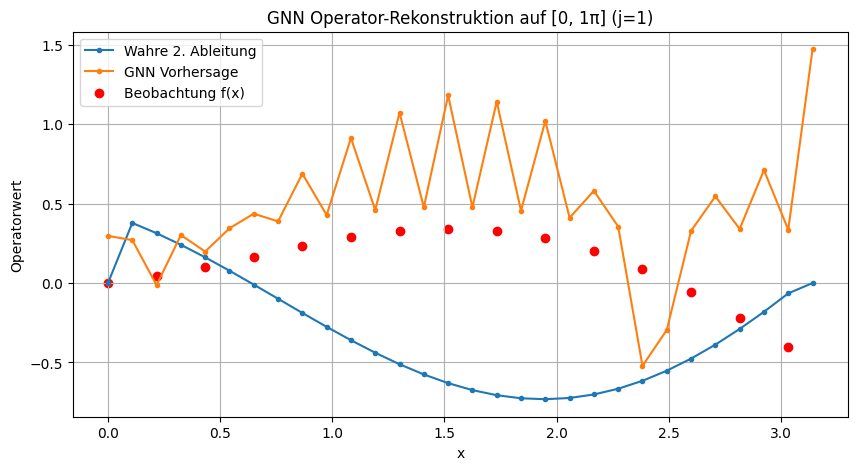

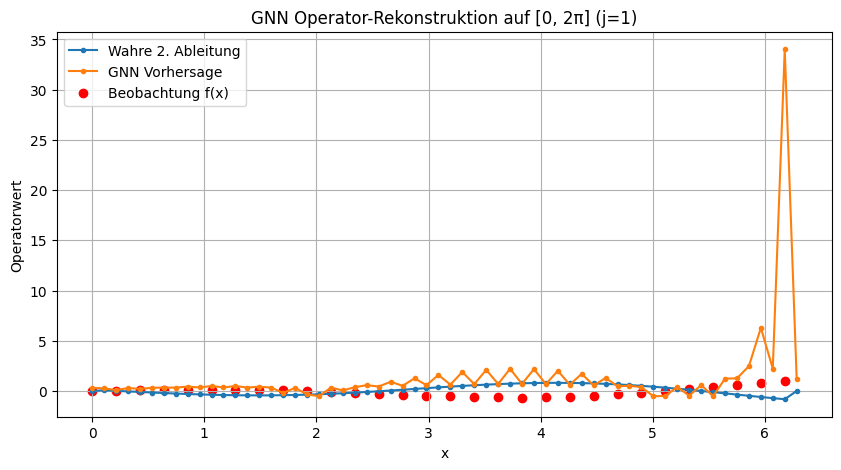

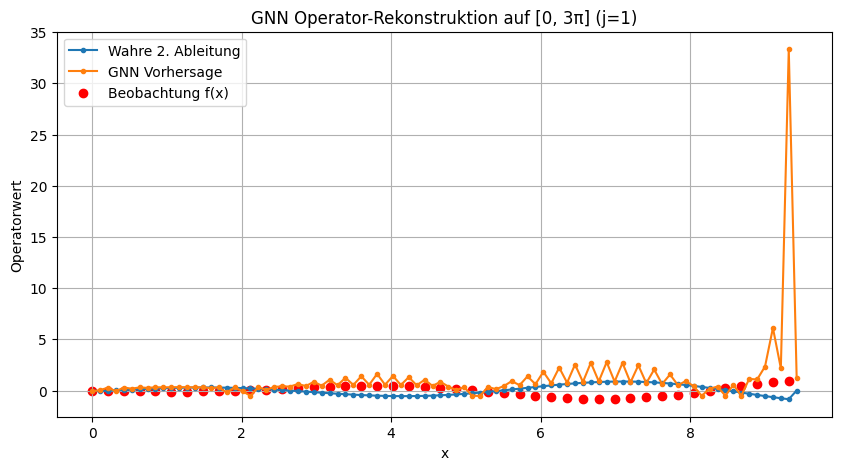

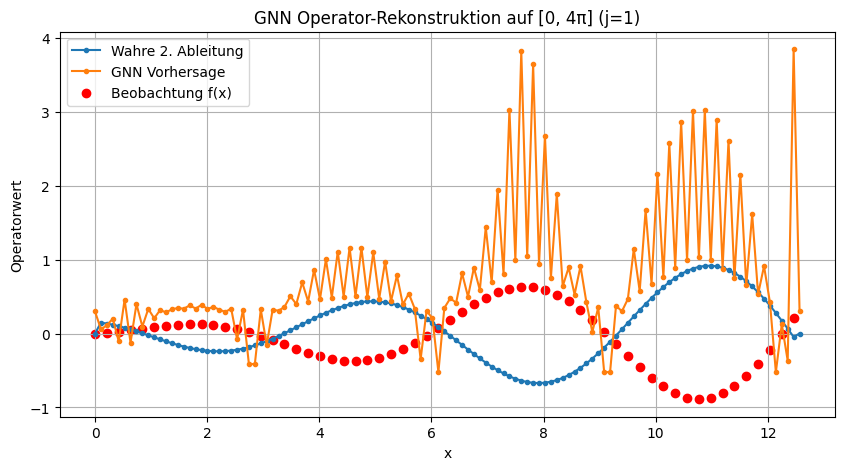

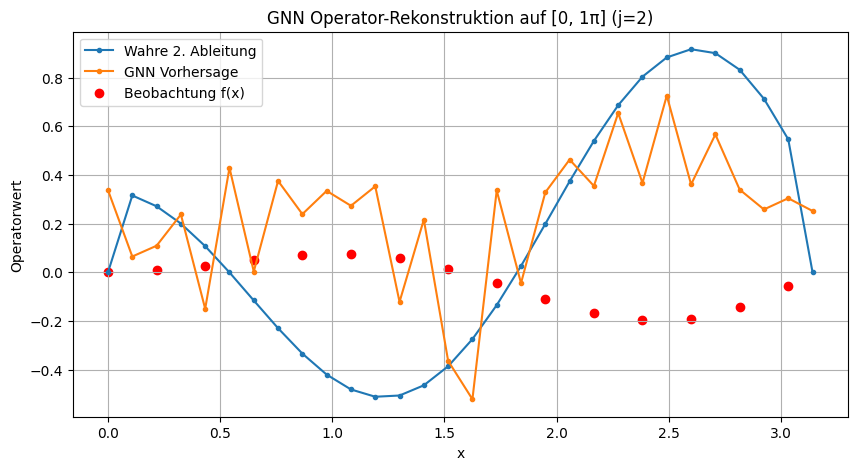

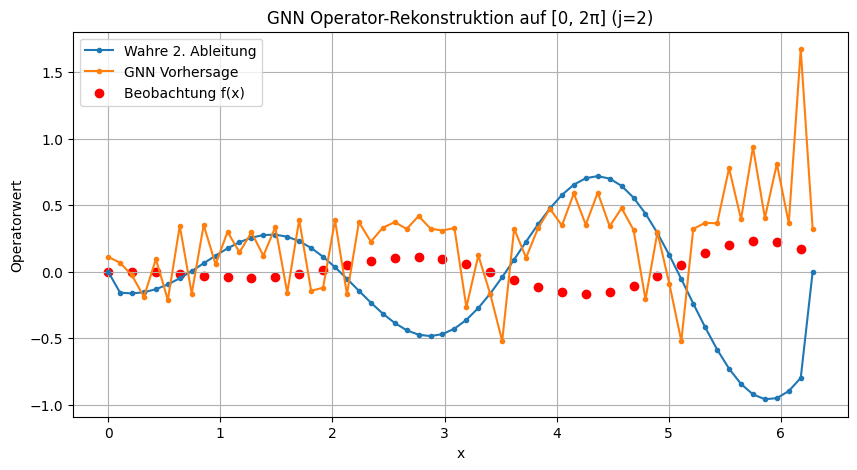

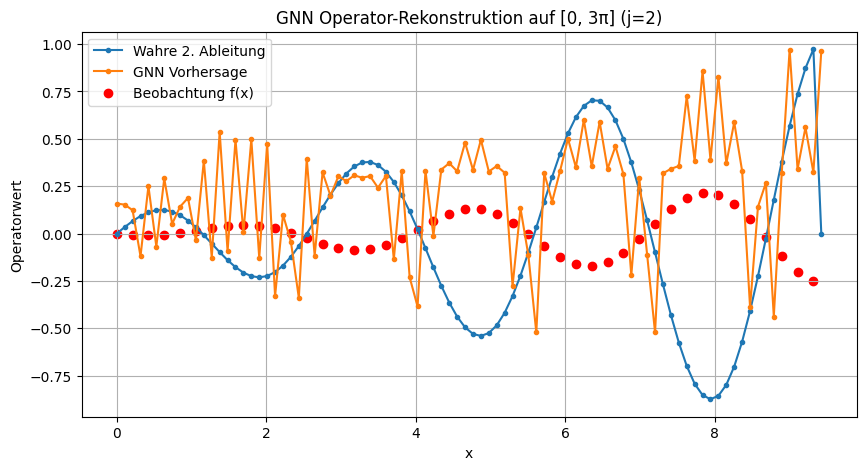

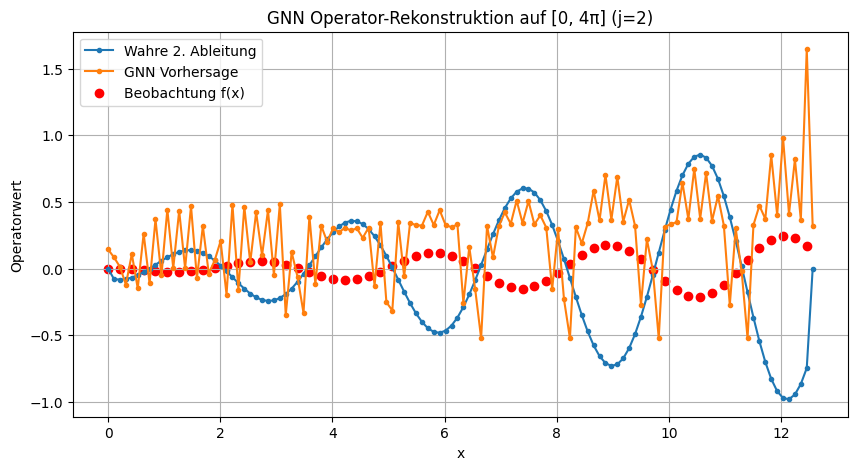

In [2]:
M=2
# --------------- Testfunktion -------------------
def run_test(j, jj):
    """
    j: Parameter zur Frequenzvariation (zusätzlicher Cosinus-Faktor)
    jj: Skaliert das Intervall [0, jj * π]
    """
    N_test = jj * 30
    x_test_grid = torch.linspace(0, jj * np.pi, N_test)
    dx_test = (jj * np.pi) / (N_test - 1)

    # Testfunktion mit zufälliger Phase: Kombination von cos(x+phase) und cos((j-1)x)
    phi_test = torch.rand(1).item() * 2 * np.pi
    f_test = lambda x: x*torch.cos((1.0*j)*x + phi_test)
    y_test = f_test(x_test_grid)

    # Ziel: Berechne die wahre zweite Ableitung (als Vergleich)
    y_target = second_derivative(y_test, dx_test)
    y_target_max = torch.max(torch.abs(y_target))+1
    y_test = y_test/y_target_max
    y_target = y_target/y_target_max

    # Beobachtungen: Nur an jedem M-ten Punkt (von der ursprünglichen Funktion)
    mask = torch.zeros(N_test)
    mask[::M] = 1.0
    obs = y_test * mask
    x_feat_test = torch.stack([obs, mask], dim=1)

    # K-Nachbarn + Self-Loops für Testgitter
    edges = []
    for i in range(N_test):
        edges.append((i, i))  # Self-loop
        for k in range(1, K + 1):
            if i - k >= 0:
                edges.append((i, i - k))
            if i + k < N_test:
                edges.append((i, i + k))
    edge_index_test = torch.tensor(edges).T

    # Vorhersage des gelernten Operators
    model.eval()
    with torch.no_grad():
        pred_test = model(x_feat_test, edge_index_test)

    # Visualisierung:
    plt.figure(figsize=(10, 5))
    # Wahre zweite Ableitung
    plt.plot(x_test_grid, y_target, '.-', label="Wahre 2. Ableitung")
    # Vorhersage des GNN
    plt.plot(x_test_grid, pred_test, '.-', label="GNN Vorhersage")
    # Optional: Streuung der Originalfunktionswerte (Beobachtungen)
    plt.scatter(x_test_grid[::M], y_test[::M], color='red', label="Beobachtung f(x)")
    plt.title(f"GNN Operator-Rekonstruktion auf [0, {jj}π] (j={j})")
    plt.xlabel("x")
    plt.ylabel("Operatorwert")
    plt.grid(True)
    plt.legend()
    plt.show()

# --------------- Anwendung auf verschiedene Intervalle -------------------
for j in range(1, 3):
    for jj in range(1, 5):
        run_test(j, jj)